In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
import tensorflow_datasets as tfds
ds ,info = tfds.load('mnist', split='train', with_info=True)
# print(info)

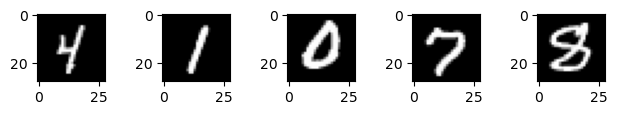

In [56]:
iterator = ds.as_numpy_iterator()
n_subplots = 5
fig, axes = plt.subplots(1, n_subplots)
plt.tight_layout()
for i in range(n_subplots):
    ax = axes[i]
    example = iterator.next()
    img, label = example['image'], example['label']
    ax.imshow(img, cmap='gray')

In [69]:
import numpy as np
ds = tfds.load('mnist')
ds_train = ds['train']
X_train = np.array([example['image'] for example in ds_train], dtype=np.float32)
X_train = X_train / 255 # rescaling in range [0,1]
X_train = np.array(X_train > 0.05, dtype=np.float32)
X_train.shape

(60000, 28, 28, 1)

In [ ]:
import sys
sys.path.append('..')
from auto_encoder import AutoEncoder

img_shape = X_train.shape[1:]
n_bottleneck = 2

encoder_network = tf.keras.Sequential(
    layers = [tf.keras.layers.Input(shape=img_shape),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=n_bottleneck, activation='linear')],
    name = 'encoder',
)

decoder_network = tf.keras.Sequential(
    layers = [tf.keras.layers.Input(shape=[n_bottleneck,]),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=64, activation='relu'),
              tf.keras.layers.Dense(units=np.prod(img_shape), activation='relu'),
              tf.keras.layers.Reshape(target_shape=img_shape),],
    name = 'decoder'
)

auto_encoder = AutoEncoder(encoder_network, decoder_network)
auto_encoder.compile(loss=tf.keras.losses.MeanSquaredError())
auto_encoder.fit(x=X_train, y=X_train, batch_size=512, epochs=100)

In [85]:
import sys
sys.path.append('..')
from auto_encoder import AutoEncoder

encoder_network = tf.keras.Sequential(
    layers = [tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
               tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(n_bottleneck),],
    name = 'encoder',
)
encoder_network.summary()

decoder_network = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(n_bottleneck,)),
        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
        tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(
            filters=32, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=3, strides=1, padding='same'),
    ]
)
decoder_network.summary()

auto_encoder = AutoEncoder(encoder_network, decoder_network)
auto_encoder.compile(loss=tf.keras.losses.MeanSquaredError())
auto_encoder.fit(x=X_train, y=X_train, batch_size=512, epochs=100)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 93,698
Trainable params: 93,698
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________

In [60]:
# print(np.array([img]).shape)

x = tf.constant(X_train[0])
x = tf.reshape(x, [-1, 28, 28, 1])
x.shape
y = encoder_network.call(x)
y.shape
z = decoder_network(y)
z.shape

TensorShape([1, 28, 28, 1])

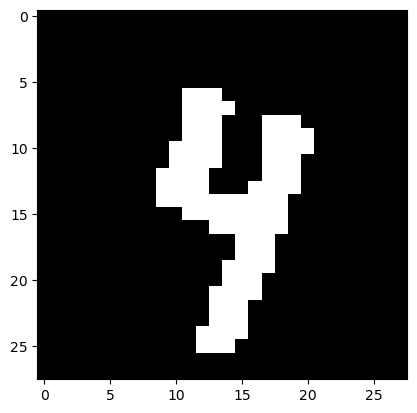

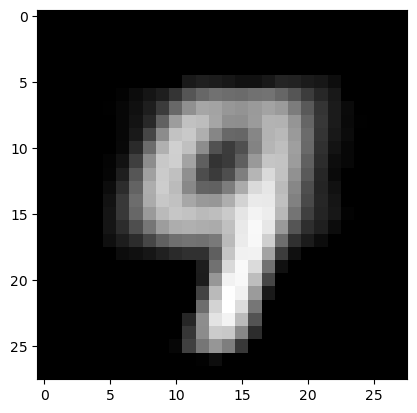

In [82]:
example = X_train[25]
plt.imshow(example, cmap='gray')
plt.show()
example = np.reshape(example, [-1, *example.shape])
encoded = auto_encoder.encoder(example)
decoded = auto_encoder.decoder(encoded)
plt.imshow(decoded[0], cmap='gray')
plt.show()

In [30]:
np.arange(0,10)+0.5

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

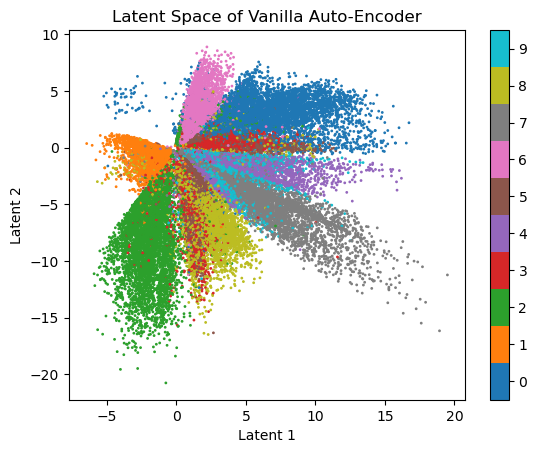

In [37]:
y_train = np.array([example['label'] for example in ds_train], dtype=np.float32)

encoded = auto_encoder.encoder(X_train)
scatter = plt.scatter(x=encoded[:,0], y=encoded[:,1], c=y_train, s=1, cmap='tab10', vmin=min(y_train)-0.5, vmax=max(y_train)+0.5)
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
cbar = plt.colorbar(ticks=np.arange(10))
plt.title('Latent Space of Vanilla Auto-Encoder')
plt.show()


In [50]:
# Mnist Manifold
import scipy 

# linear spaced coordinates on the unit-square
x1 = np.linspace(0.01, 0.99, 10)
x2 = np.linspace(0.01, 0.99, 10)

# transformed coordinates on the manifold
# note: ppf is the inverse cdf
z1 = scipy.stats.norm.ppf(x1)
z2 = scipy.stats.norm.ppf(x2)

zgrid = np.dstack(np.meshgrid(z1, z2))
z = np.reshape(zgrid, [-1, 2])
z.shape

(100, 2)

In [40]:
prior.cdf()

TypeError: cdf() missing 1 required positional argument: 'x'

In [ ]:
# from autoencoder import SparseAutoEncoder

# img_shape = X_train.shape[1:]
# n_bottleneck = 2

# encoder_network = tf.keras.Sequential(
#     layers = [tf.keras.layers.Input(shape=img_shape),
#               tf.keras.layers.Flatten(),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=n_bottleneck, activation='linear')],
#     name = 'encoder',
# )

# decoder_network = tf.keras.Sequential(
#     layers = [tf.keras.layers.Input(shape=[n_bottleneck,]),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=64, activation='relu'),
#               tf.keras.layers.Dense(units=np.prod(img_shape), activation='relu'),
#               tf.keras.layers.Reshape(target_shape=img_shape),],
#     name = 'decoder'
# )

# sparse_auto_encoder = SparseAutoEncoder(encoder_network, decoder_network)
# sparse_auto_encoder.compile(loss=tf.keras.losses.MeanSquaredError())
# # sparse_auto_encoder.compute_loss()
# sparse_auto_encoder.fit(x=X_train, y=X_train, batch_size=512, epochs=100)